In [1]:
from pprint import pprint
import data_reader
import cutoff_threshold
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

In [2]:
path2submits  = 'iui20_ideaSubmitsPart2.csv'
path2requests = 'iui20_inspirationRequestsPart2.csv'
seconds_per_bucket = 15
train_percentage = 0.7

In [3]:
#load data as sessions
sessions = data_reader.load_data_as_sessions_dict(path2submits, path2requests, seconds_per_bucket)
# calculate avoiders and seekers
sessions = data_reader.add_avoiders_undetermined_and_seekers(sessions)
# create train and test set of worker ids
train_worker_ids, test_worker_ids = data_reader.split_worker_ids_into_train_test(sessions, train_percentage=train_percentage)
print(len(sessions))

41


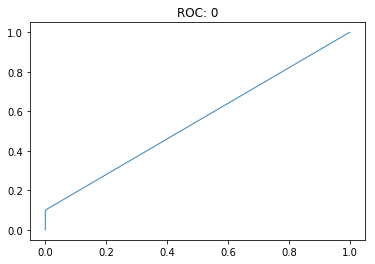

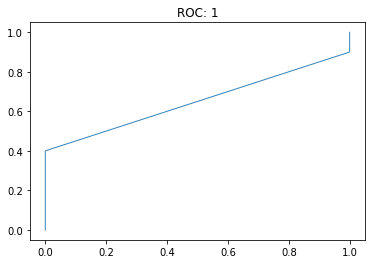

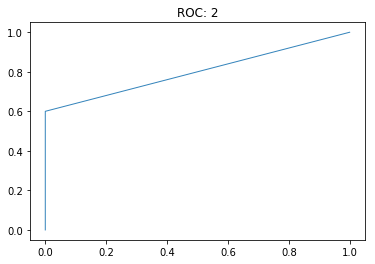

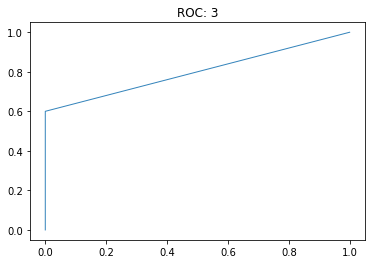

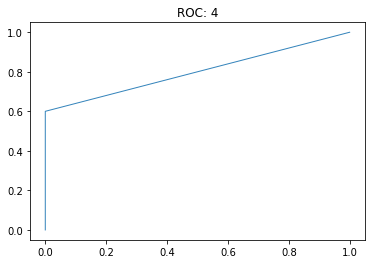

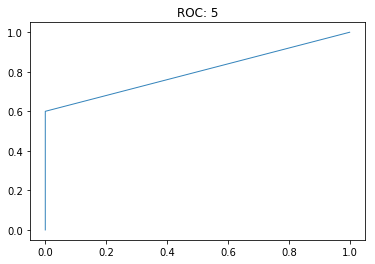

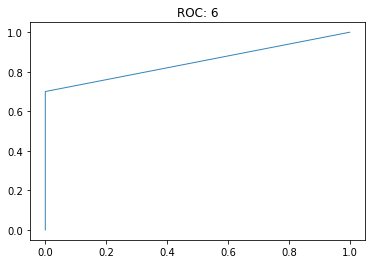

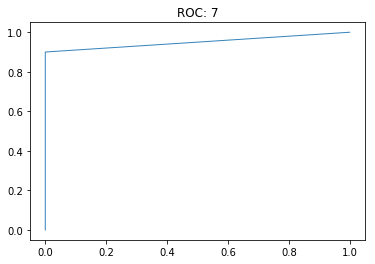

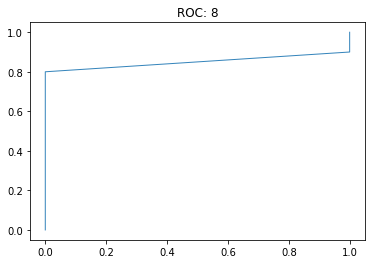

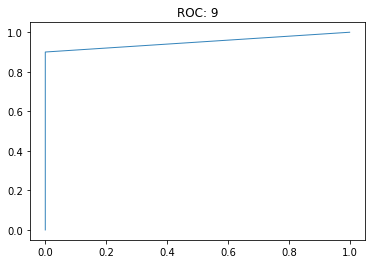

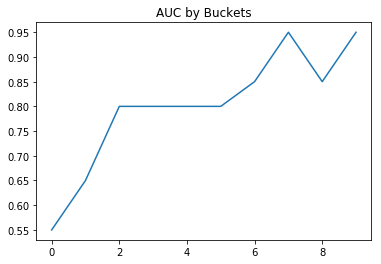

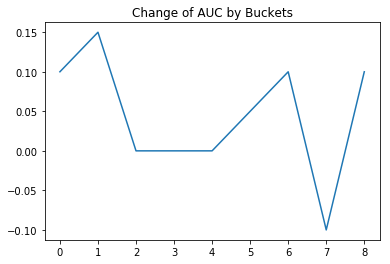

[array([[ 8.,  0.],
       [83.,  9.]]),
 array([[ 8.,  0.],
       [55., 37.]]),
 array([[ 8.,  0.],
       [37., 55.]]),
 array([[ 8.,  0.],
       [37., 55.]]),
 array([[ 8.,  0.],
       [37., 55.]]),
 array([[ 8.,  0.],
       [37., 55.]]),
 array([[ 8.,  0.],
       [28., 64.]]),
 array([[ 8.,  0.],
       [ 9., 83.]]),
 array([[ 8.,  0.],
       [18., 73.]]),
 array([[ 8.,  0.],
       [ 9., 83.]])]


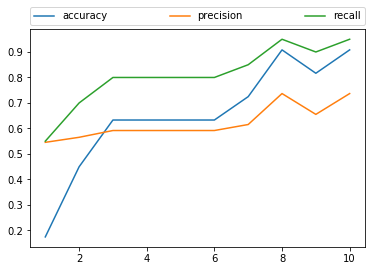

In [4]:
# iterate through different numbers of buckets
# train a classifier for each different numbers of buckets
# test on test examples
# get roc curve
conf_matrices    = []
accuracies       = []
balanced_accs    = []
precisions_micro = []
recalls_micro    = []
aucs             = []
max_number_of_buckets = 40
for nr_of_buckets in range(1, max_number_of_buckets, int(60/seconds_per_bucket)):
    x_tr, y_tr, x_te, y_te = data_reader.create_train_test_dataset(nr_of_buckets, train_worker_ids, test_worker_ids, sessions, train_percentage)
    
    sample_weight = 1.0 * np.bincount(y_tr) / len(y_tr)
    sample_weight = [sample_weight[y_tr[i]] for i in range(len(y_tr))]
    
    #clf = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
    clf = RandomForestRegressor(200)
    clf.fit(x_tr, y_tr, sample_weight=sample_weight)
    y_pre = clf.predict(x_te)
    
    sample_weight = 1.0 * np.bincount(y_te) / len(y_te)
    sample_weight = [sample_weight[y_te[i]] for i in range(len(y_te))]
    #print(y_te)
    #print(sample_weight)
    
    # roc curve
    fpr, tpr, thresholds = roc_curve(y_te, y_pre, pos_label=None, sample_weight=sample_weight)
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = interp(mean_fpr, fpr, tpr)
    tprs[0] = 0.0
    
    aucs.append(auc(fpr, tpr))
    #aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.9)
    plt.title('ROC: ' + str(int(nr_of_buckets / int(60/seconds_per_bucket))))
    plt.show()
    
    # other metrics
    
    best_t, best_pred = cutoff_threshold.find_thresholds(y_pre, y_te)
    thres = cutoff_threshold.find_optimal_cutoff(y_te, y_pre)
    #print(best_t, best_acc)
    #print('here: ', thres)
    conf_matrices   .append(confusion_matrix(y_te, best_pred, sample_weight=sample_weight))
    accuracies      .append(accuracy_score  (y_te, best_pred, sample_weight=sample_weight))
    precisions_micro.append(precision_score (y_te, best_pred, average='macro', sample_weight=sample_weight))
    recalls_micro   .append(recall_score    (y_te, best_pred, average='macro', sample_weight=sample_weight))
    
    
plt.plot(aucs)
plt.title('AUC by Buckets')
plt.show()

plt.plot(np.array(aucs[1:])-np.array(aucs[:-1]))
plt.title('Change of AUC by Buckets')
plt.show()

# [[tn, fp, fn, tp], ...]
#conf_matrices = np.array([conf_m.ravel() for conf_m in conf_matrices])

#pprint(precisions_micro)
pprint([(100*(conf/np.sum(conf))).round() for conf in conf_matrices])

#plt.xticks(range(1, max_number_of_buckets))
steps = int(max_number_of_buckets / int(60/seconds_per_bucket))
plt.plot(range(1, steps+1), accuracies,       label='accuracy')
plt.plot(range(1, steps+1), precisions_micro, label='precision')
plt.plot(range(1, steps+1), recalls_micro,    label='recall')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.show()

/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/bobby/Env/tensorflow/lib/python3.6/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


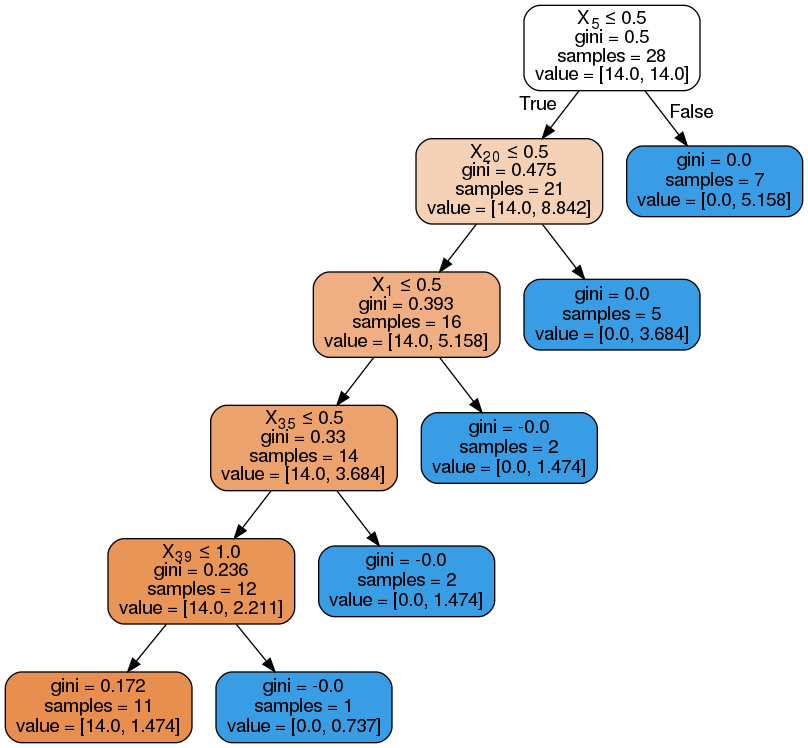

In [5]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

train_percentage = 1.0
x_tr, y_tr, x_te, y_te = data_reader.create_train_test_dataset(int(max_number_of_buckets), train_worker_ids, test_worker_ids, sessions, train_percentage)
clf = DecisionTreeClassifier(max_depth=5, min_impurity_split=0.1, class_weight='balanced')
clf.fit(x_tr, y_tr)
    
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())